
# Document Scanner with OpenCV & OCR 
This notebook scans a document using OpenCV by detecting edges, finding contours, and applying a perspective transformation.


In [ ]:

# Install required libraries (only needed once per environment)
!pip install opencv-python-headless numpy matplotlib pytesseract


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pytesseract
import os

# Function to display images in Jupyter Notebook
def show_image(img, title="Image"):
    """ Display an image using matplotlib """
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB for correct colors
    plt.figure(figsize=(10, 5))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()


Original image shape: (1280, 960, 3)


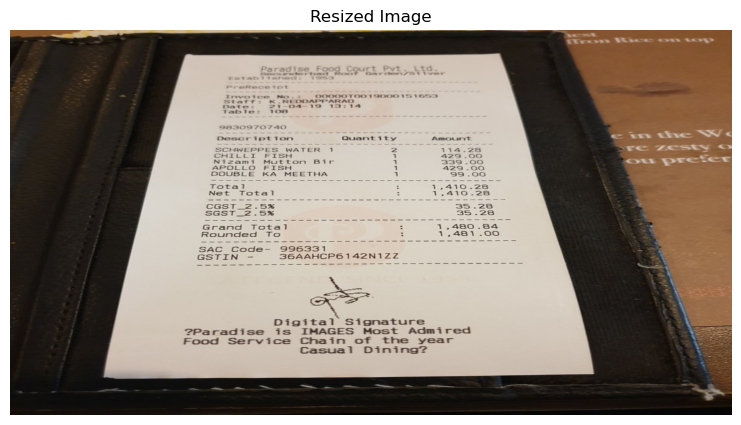

In [35]:

# Load image with dynamic file checking
image_path = 'bill02.jpg'
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found at {image_path}. Please check the path.")

img = cv.imread(image_path)
print("Original image shape:", img.shape)

# Resize the image
img = cv.resize(img, (1500, 800))
show_image(img, "Resized Image")


## Convert to Grayscale

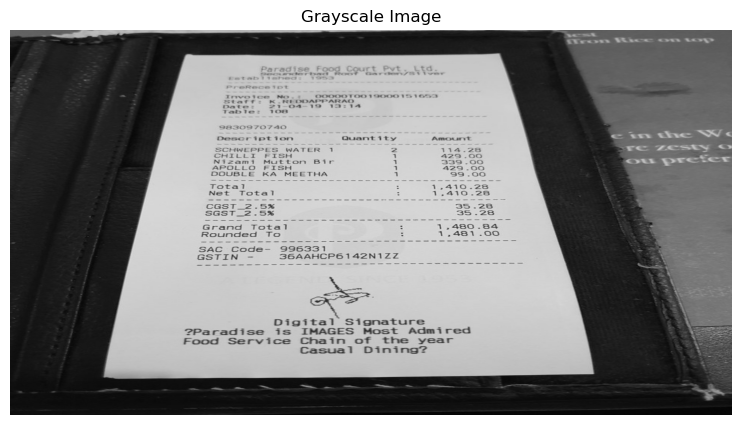

In [36]:

orig = img.copy()
gray = cv.cvtColor(orig, cv.COLOR_BGR2GRAY)
show_image(gray, "Grayscale Image")


## Apply Gaussian Blur

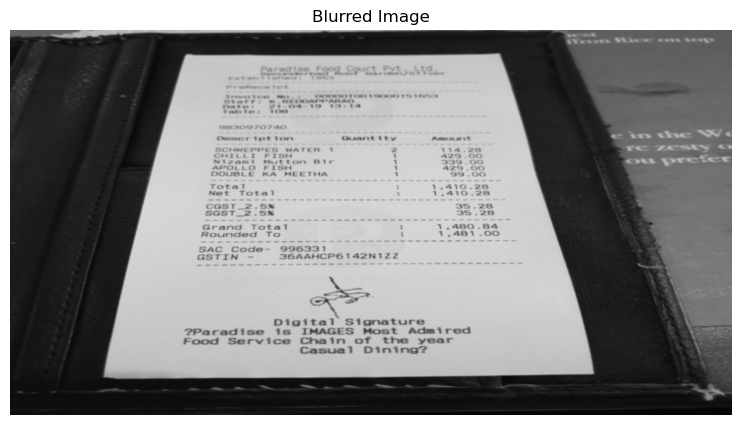

In [37]:

blurred = cv.GaussianBlur(gray, (5, 5), 0)
show_image(blurred, "Blurred Image")


## Edge Detection with Canny

Edge Detection Applied


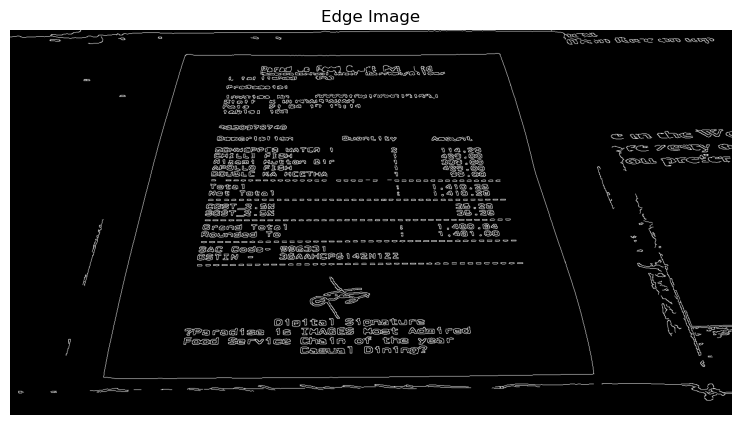

In [38]:

# Allow user to modify thresholds
low_threshold = 50
high_threshold = 150

edge = cv.Canny(blurred, low_threshold, high_threshold)
print("Edge Detection Applied")
show_image(edge, "Edge Image")


## Find Contours in the Edge Image

In [39]:

contours, _ = cv.findContours(edge, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
print("Number of contours detected:", len(contours))

# Sort contours by area
contours = sorted(contours, reverse=True, key=cv.contourArea)

# Identify the document boundary
target = None
for c in contours:
    p = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * p, True)
    if len(approx) == 4:
        target = approx
        break

if target is not None:
    print("Target shape:", target.shape)
else:
    print("No quadrilateral found. Try adjusting preprocessing parameters.")


Number of contours detected: 1562
Target shape: (4, 1, 2)


## Reorder Points for Perspective Transformation

In [40]:

def reorder(h):
    h = h.reshape((4, 2))
    hnew = np.zeros((4, 2), dtype=np.float32)

    add = h.sum(axis=1)
    hnew[3] = h[np.argmin(add)]
    hnew[1] = h[np.argmax(add)]

    diff = np.diff(h, axis=1)
    hnew[0] = h[np.argmin(diff)]
    hnew[2] = h[np.argmax(diff)]

    return hnew


## Apply Perspective Transformation

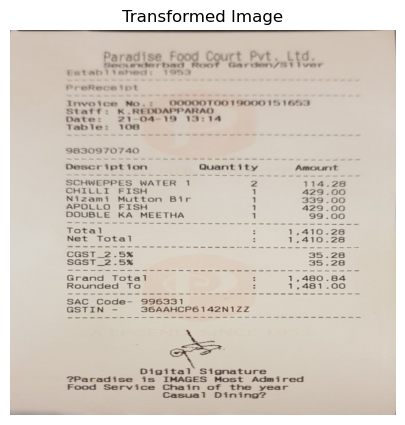

In [41]:

if target is not None:
    input_representation = reorder(target)
    output_map = np.float32([[0, 0], [800, 0], [800, 800], [0, 800]])

    # Perspective transformation
    M = cv.getPerspectiveTransform(input_representation, output_map)
    ans = cv.warpPerspective(orig, M, (800, 800))
    rot_ans = cv.rotate(ans, cv.ROTATE_90_CLOCKWISE)

    show_image(rot_ans, "Transformed Image")
else:
    print("Skipping perspective transformation as no document was detected.")
